In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.json
train.json



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_json('../input/train.json')
test = pd.read_json("../input/test.json")

In [4]:
#inc_angle to Numeric from float
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

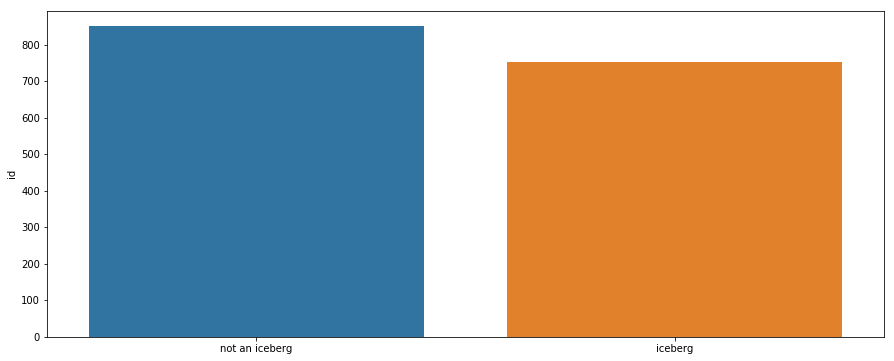

In [5]:
f,ax = plt.subplots(1,1,figsize=(15,6))
sns.barplot(x=['not an iceberg','iceberg'],y=train.groupby(['is_iceberg'],as_index=False).count()['id'])
plt.show()

In [6]:
train['inc_angle'].describe() # NA exsists

count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64

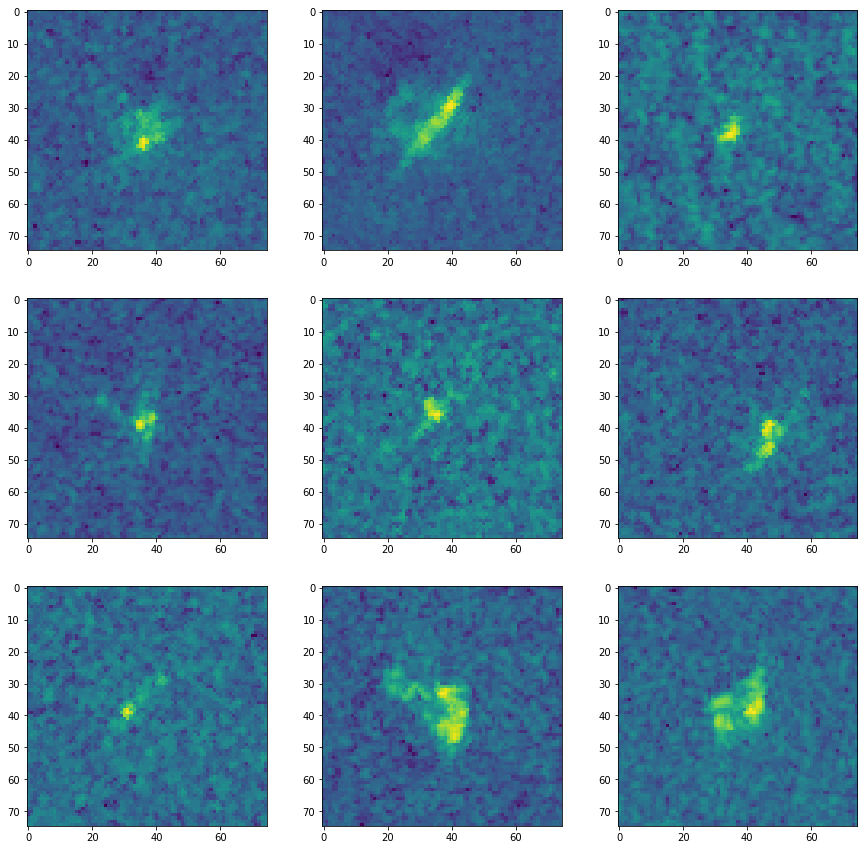

In [7]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)
#Plotting Images:Iceberg
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr)
plt.show()


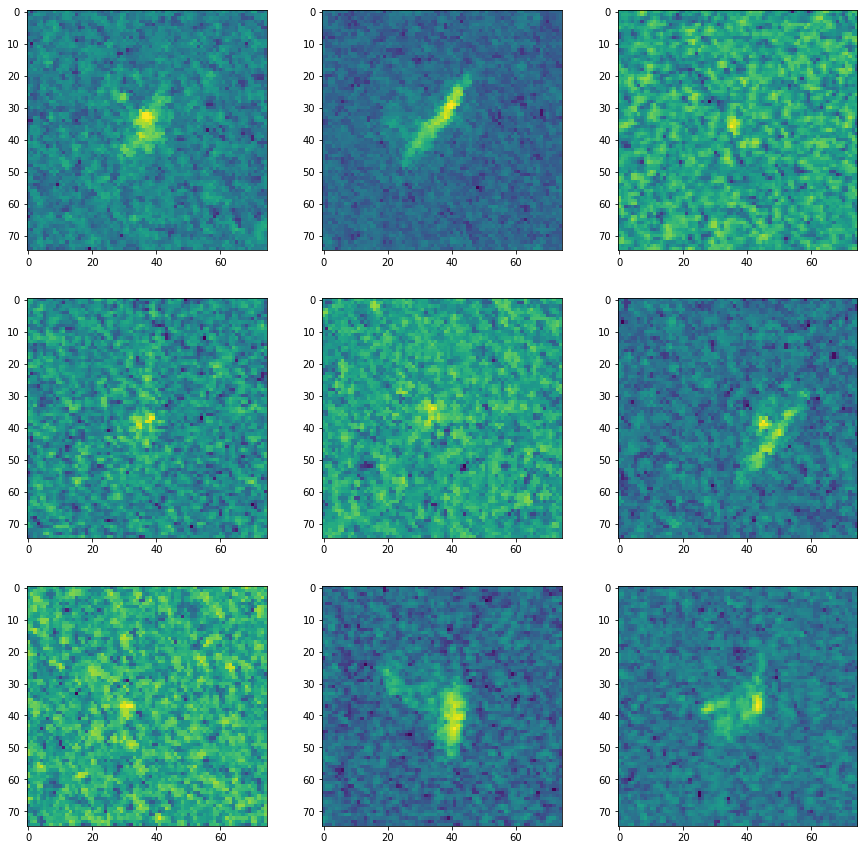

In [8]:
#Plotting Images:Iceberg Band 2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr)
plt.show()

In [9]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)    

In [10]:
#Image with 3 Bands
Xtrain = get_scaled_imgs(train)
Ytrain = np.array(train['is_iceberg'])

In [11]:
import cv2
def transform_image(image,ang_range,shear_range,trans_range):
# Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
# Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    
    return image

In [12]:
# Augmentation Translation + Rotation
aug_imgs = []
for i in range(0,Xtrain.shape[0]):
    aug_imgs.append(transform_image(Xtrain[i],5,5,2))

In [13]:
# Flip Images
def get_more_images(imgs):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v= np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    aug_image=np.array(aug_imgs)
       
    more_images = np.concatenate((imgs,v,h,aug_image))
    
    return more_images

In [14]:
Xtr_more = get_more_images(Xtrain) 
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain,Ytrain))

In [15]:
from sklearn.model_selection import train_test_split
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(Xtr_more, Ytr_more, random_state=1, train_size=0.75)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
# Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


In [ ]:
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

#     mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    mypotim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    gmodel.compile(loss='binary_crossentropy',optimizer=mypotim,metrics=['accuracy'])
    gmodel.summary()
    return gmodel

In [ ]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_aug_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [ ]:
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=20,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#Submission
Xtest = get_scaled_imgs(test)
predicted_test=gmodel2.predict_proba(Xtest)
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('submission3.csv', index=False)